# Triple calculation  
In this notebook triples are calculated from graph data.   
1. Load prepared graph and markup
2. Run triple calculation
3. Get info about triple activity during different labels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from triple_patterns import find_triples
from triple_patterns import get_triple_edges

#### 1. Load prepared graph and markup

Graph defined as three-dimensional array $T \times N \times N$, where $T = nt \div 8$ 
($nt$ - time in frames).  
This is because the graph is compressed, and bit mask in $uint8$ data type stores ones in the positions corresponding to the presence of an edge at that moment in time, $N$ - number of cells.  
The figure below shows the graph represented at three distinct frames.

In [2]:
graph_path = r"..\data\graph.npz"
graph_data = np.load(graph_path)
graph = graph_data["graph"]
graph.shape

(120, 10, 10)

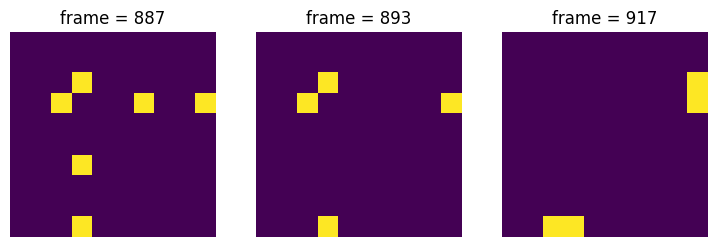

In [3]:
unpacked_graph = np.unpackbits(graph, axis=0)
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
frames = [887, 893, 917]
for idx, ax in enumerate(axes):
    ax.imshow(unpacked_graph[frames[idx]])
    ax.set_title(f"frame = {frames[idx]}")
    ax.axis('off')

Markup saved as a DataFrame, but for further analysis we transform it to dict, where key is a number of label and value is an array of zeros and ones, where ones mark moments of time, when label was active.

In [4]:
markup_path = r"..\data\markup.csv"
markup_df = pd.read_csv(markup_path, index_col=0)
markup = markup_df.to_dict(orient='list')
markup = {key: np.array(value) for key, value in markup.items()}
markup_df.head()

,1,2,3
0,False,True,False
1,False,True,False
2,False,True,False
3,False,False,True
4,False,False,True


#### 2. Run triple calculation

Only graph is needed for triple search. The result of this process is two arrays:  
1. Array of triples with size $M\times3$, where M - number of finding triples. 
2. Array with triple activity in time with size $M\times T$, where $T = nt \div 8$. Array contains only $0$ and $1$, where $1$ signify moments of time, where triple was active.  

Triple activity is shown in the figure below, where the vertical axis represents the count of detected triples and the horizontal axis represents time in frames.

In [5]:
triples, triple_activity = find_triples(graph)
triples

(120, 10, 10)
Good triples: 6


array([[2, 3, 6],
       [2, 3, 9],
       [2, 6, 3],
       [2, 9, 3],
       [3, 2, 6],
       [6, 3, 9]])

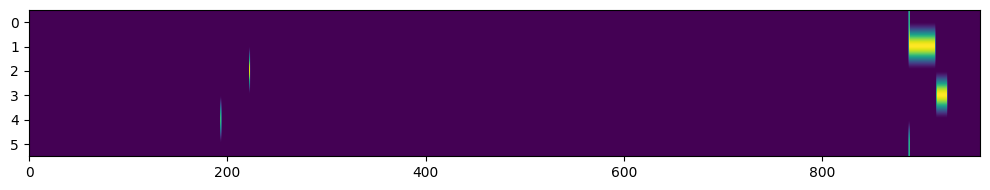

In [6]:
unpacked_triple_activity = np.unpackbits(triple_activity, axis=1)
fig, ax = plt.subplots(figsize=(10, 2))
ax.imshow(unpacked_triple_activity[:, :], aspect="auto")
ax.set_yticks(np.arange(0, len(triples)))
plt.tight_layout()

#### 3. Get info about triple activity during different labels

This step allows to get how triple was active during different labels. The resulting array has shape $M \times L$, where $M$ - number of found triples, $L$ - number of labels in markup.  
For convenience the result was transformed to DataFrame. Columns `frame_count_label_x` show how many frames triple was active during label x.

In [7]:
triple_info = get_triple_edges(triple_activity, markup, is_markup_packed=False)
df = pd.DataFrame(triple_info, index=tuple(triples), columns=["frame_count_label_1", "frame_count_label_2", "frame_count_label_3"], dtype="int")
df

,frame_count_label_1,frame_count_label_2,frame_count_label_3
"[2, 3, 6]",0,0,1
"[2, 3, 9]",16,5,6
"[2, 6, 3]",0,1,0
"[2, 9, 3]",0,0,11
"[3, 2, 6]",1,0,0
"[6, 3, 9]",0,0,1


In [8]:
path_triple_data = r"..\data\triple_data.npz"
triple_data = np.savez(path_triple_data, triples=triples, triple_activity=triple_activity, triple_info=triple_info)